# Analyzing LES tracer releases

## Comparing calm condtions and windy condtions

###Using Holstag & Moeng (1991) and Garrat p. 160

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import glob
import os

### Pulling in the .nc files

###     The windy data - 15 min run with output every 30 seconds
    
###     The calm data - 120 min run with output every 4 min
####    I deciced to only look at the 1st 120 mins using every 4th output file for the calm data to cut down on the # of files to analyze and look at a comparable # of  of samples for the two runs
        

In [2]:
def sort_name(name):
    name,ftype = name.split('.')
    time = name.split('_')[-1]
    return time

path = '/home/wesley/atsc500/notebooks/ProjData'
os.chdir(path)

the_files_windy = glob.glob('windy/NCHAPP1_meanwindB_16*.nc')
the_files_calm = glob.glob('calm/NCHAPP1_2patchF_16*.nc')

the_files_windy.sort(key=sort_name)
the_files_calm.sort(key=sort_name)

# Class containing most of the functions

In [3]:
class Data(object):
    def __init__(self,the_files):
        self.save_nc = []
        for count, nc in enumerate(the_files):
            self.save_nc.append(Dataset(nc, 'r'))
        z = self.save_nc[0].variables['z'][...]
        p = self.save_nc[0].variables['p'][...] * 100
        shp = self.save_nc[0].variables['TABS'][...].shape
        self.y=shp[2]
        self.x=shp[3]
        self.count = count +1
        self.top=np.where(np.abs(z - 800.) < 1.)[0][0]
        self.z = z[ :self.top]
        self.p = p[ :self.top]
        
    def Stats (self,Var):
        Profile = Var.mean(axis=3).mean(axis=2)
        Pert = Var-Profile[:,:,np.newaxis,np.newaxis]
        return(Profile,Pert)
    
    def height(self):
        self.h_id=np.zeros(self.count)
        self.zi = np.zeros(self.count)
        self.Ct = np.zeros(self.count)
        self.z_zi = np.zeros(shape =(self.count,self.top))
        self.entFlux = np.zeros(self.count)
        self.meanC = np.zeros(self.count)
        for i in range(0,self.count):
            x = np.where(self.T_flux_Pro[i,:]<0)[0]
            y = x[0] + np.where(self.T_flux_Pro[i,x[0]:x[-1]]==np.min(self.T_flux_Pro[i,x[0]:x[-1]]))[0][0]
            self.h_id[i]=y
            self.zi[i]=self.z[y]
            self.z_zi[i,:] = self.z/self.z[y]
            self.Ct = (self.Tr_Pro[i,y]-self.Tr_Pro[i,y-1])/(self.z[y]-self.z[y-1])
            self.entFlux[i] = self.Tr_flux_Pro[i,y]
            self.meanC[i] = self.Tr_Pro[i,0:y].mean()
        
    def Extract(self,ymin,xmin,ymax,xmax):
        Rcp = 0.286
        y = ymax-ymin
        x = xmax-xmin
        self.T = np.zeros(shape = (self.count,self.top,y,x))
        #self.U = np.zeros(shape = (self.count,self.top,y,x))
        #self.V = np.zeros(shape = (self.count,self.top,y,x))
        self.W = np.zeros(shape = (self.count,self.top,y,x))
        self.Tr = np.zeros(shape = (self.count,self.top,y,x))
        for count, nc in enumerate(self.save_nc):
            self.T[count,:,:,:] = nc.variables['TABS'][0, :self.top,ymin:ymax,xmin:xmax]
            #self.U[count,:,:,:] = nc.variables['U'][0, :self.top, :, :]
            #self.V[count,:,:,:] = nc.variables['V'][0, :self.top, :, :]
            self.W[count,:,:,:] = nc.variables['W'][0, :self.top,ymin:ymax,xmin:xmax]
            self.Tr[count,:,:,:] = nc.variables['TR01'][0, :self.top,ymin:ymax,xmin:xmax]
        self.T_abs=self.T[:,:,:,:].mean(axis=3).mean(axis=2)
        self.T=self.T*(1000/self.p[np.newaxis,:,np.newaxis,np.newaxis])**Rcp
        self.T_Pro,self.T_Per = self.Stats(self.T)
        self.W_Pro,self.W_Per = self.Stats(self.W)
        self.Tr_Pro,self.Tr_Per = self.Stats(self.Tr)
        self.T_flux = (self.T_Per*self.W_Per)
        self.T_flux_Pro = self.T_flux.mean(axis=3).mean(axis=2)
        self.Tr_flux = (self.Tr_Per*self.W_Per)
        self.Tr_flux_Pro = self.Tr_flux.mean(axis=3).mean(axis=2)
        self.height()
            
    def Patches(self):
        x = np.where(self.Tr[0,0,:,:]>0)
        self.P1 = np.min(x[0])+2,np.min(x[1])+2,np.max(x[0])-2,np.max(x[1])-2
        self.P2 = np.min(x[0])+2,np.max(x[1])+4,np.max(x[0])-2,np.max(x[1])+4+self.P1[3]-self.P1[1]
        
    def TdBup(self):
        g=9.8
        self.wst=(np.abs(g/self.T_abs[:,1]*self.T_flux_Pro[:,1]*self.zi))**(1/3)
        ## Surface concentration gradient
        self.Cb = (self.Tr_Pro[:,2]-self.Tr_Pro[:,1])/(self.z[2]-self.z[1])
        self.gb = .4*self.z_zi**-(3/2)                               #EQ 1.3.b# Moeng & Wyngard 84
        self.gt = .7*(1-self.z_zi)**-2                               #EQ 1.3.a# Moeng & Wyngard 84
        Tr_s = self.Tr_flux_Pro[:,1] 
        self.wcBar = (Tr_s*(1-self.z_zi.T)+self.entFlux*self.z_zi.T).T  #EQ 22# Holtslag & Moeng 91 
        self.dCdZ = (-(Tr_s.T*self.gb.T + self.entFlux.T*self.gt.T)/(self.wst*self.zi)).T #EQ 22# Holtslag & Moeng 91 
        term1 = -(Tr_s/(self.wst*self.zi))
        self.Gb = -.8*(self.z_zi)**(-1/2)               #### Intgral of 1.3.b# Moeng & Wyngard 84
        self.C = self.Gb.T*term1
        self.term2 = -.7*(self.entFlux/self.wst).T/(1-self.z_zi).T
        self.C = self.C + self.term2
        self.C = self.C + self.meanC          ## Wastn' sure about the constant ..Using mean ml Concentration
        #self.C = (self.C-self.C*.1)*self.wst/Tr_s
        self.C = self.C.T


## Take a quick look at z=0 at timestep 1

In [4]:
calm = Data(the_files_calm)
calm.Extract(0,0,calm.y,calm.x)
windy = Data(the_files_windy)
windy.Extract(0,0,windy.y,windy.x)

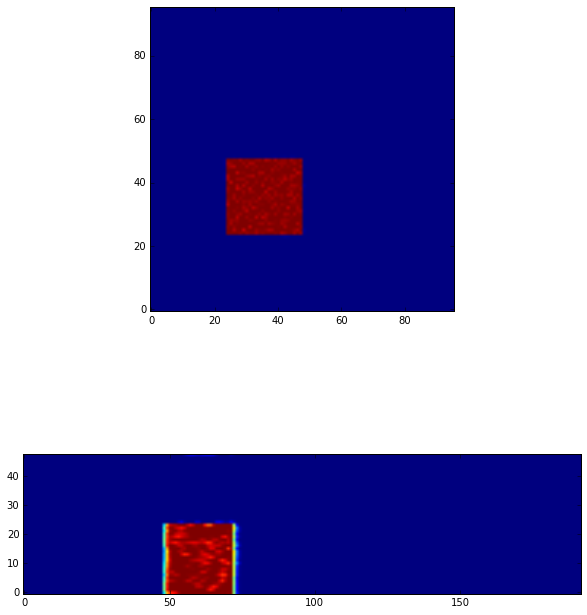

In [5]:
%matplotlib inline 
ig,ax = plt.subplots(2,1,figsize = (10,12))
ax[0].imshow(calm.Tr[0,0,:,:], origin = "lower")
ax[1].imshow(windy.Tr[0,0,:,:], origin = "lower")

# Quick look at the mean thetav & theta fluxprofiles

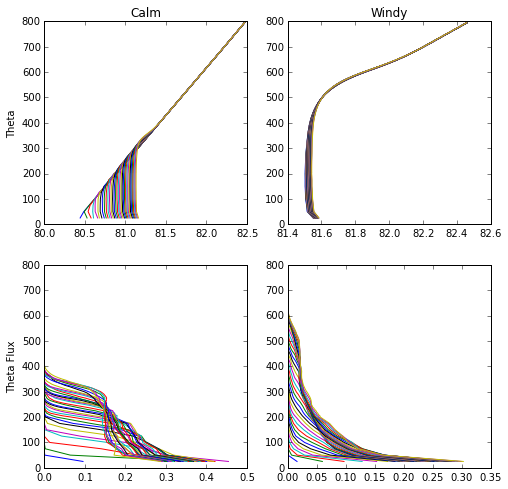

In [6]:
fig,ax = plt.subplots(2,2,figsize = (8,8))
for i in range (0,calm.count):
    ax[0][0].plot(calm.T_Pro[i,:],calm.z)
    ax[1][0].plot(calm.Tr_Pro[i,:],calm.z)
    ax[0][1].plot(windy.T_Pro[i,:],calm.z)
    ax[1][1].plot(windy.Tr_Pro[i,:],calm.z)
    
ax[0][0].set(ylabel='Theta',title='Calm')
ax[1][0].set(ylabel='Theta Flux')
ax[0][1].set(title='Windy')

# Animations of the scalar fluxes averaged over the Y axis

### I treid to imbed some animations, but after a couple hours baning my head against a wall trying to get the .mp4 writer to work, I just gave up.

In [7]:
%matplotlib qt 
import matplotlib.animation as anim


def Animate(Var,count,name):
    fig = plt.figure(figsize = (10,10))
    ims = []
    Var=Var.mean(axis=2)
    for i in range(0,count):
        ims.append([plt.imshow(Var[i,:,:], origin = "lower",vmin = -.25, vmax = 1.25)])
    ani = anim.ArtistAnimation(fig,ims,interval=100, repeat_delay=1000)
    plt.show()
Animate(calm.Tr_flux,calm.count,'Calm')
Animate(windy.Tr_flux,windy.count,'Windy')

# How well does top down, bottom up diffuision represent this?

###h - defined as the most negative heat flux in the entrainment layer

/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:75: RuntimeWarning: divide by zero encountered in power
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:78: RuntimeWarning: invalid value encountered in multiply
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: invalid value encountered in true_divide


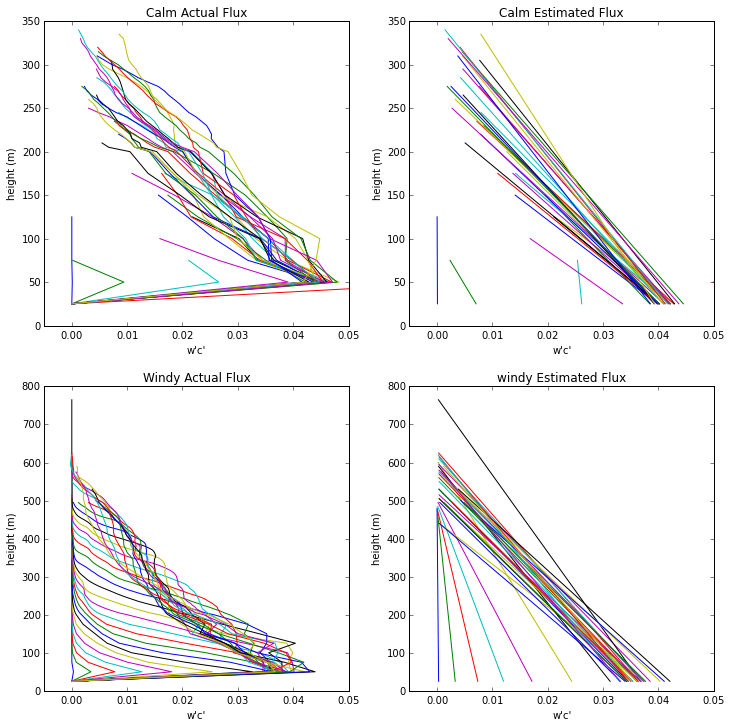

In [8]:
%matplotlib inline 
windy.TdBup()
calm.TdBup()
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_flux_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.wcBar[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_flux_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.wcBar[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(-.005,.05),xlabel="w'c'",ylabel='height (m)',title=('Calm Actual Flux'))
out=ax[0][1].set(xlim=(-.005,.05),xlabel="w'c'",ylabel='height (m)',title=('Calm Estimated Flux'))
out=ax[1][0].set(xlim=(-.005,.05),xlabel="w'c'",ylabel='height (m)',title=('Windy Actual Flux'))
out=ax[1][1].set(xlim=(-.005,.05),xlabel="w'c'",ylabel='height (m)',title=('windy Estimated Flux'))

# The flux profiles look like pretty good approximations

##   Better for the calm run when advection doesn't impact the profiles

#How about the concentration profiles?

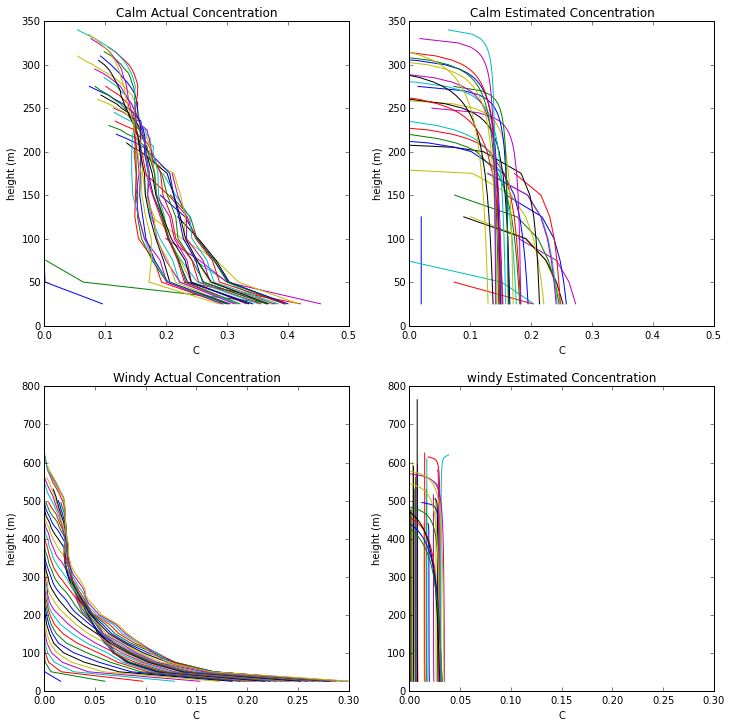

In [9]:
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.C[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.C[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(0,.5),xlabel="C",ylabel='height (m)',title=('Calm Actual Concentration'))
out=ax[0][1].set(xlim=(0,.5),xlabel="C",ylabel='height (m)',title=('Calm Estimated Concentration'))
out=ax[1][0].set(xlim=(0,.3),xlabel="C",ylabel='height (m)',title=('Windy Actual Concentration'))
out=ax[1][1].set(xlim=(0,.3),xlabel="C",ylabel='height (m)',title=('windy Estimated Concentration'))

# They don't look so good! 

       I wasn't sure about the constatnt for Garrat eq 6.45, I used the mean ML tracer concetnration

## The calm profiles look okay, but the windy profiles look a don't behave well at all

###Could be due to the inhomogenous surface fluxes?
###The decay rate of the scalar?
###Or becuase the runs are for just after the tracer relase began?

# I'll check and see if it was due to inhomegenous surface conditions

## I'll look at two sub regions.

# First I'll look at just the patch, then i'll look at a spot downwind from the patch

In [10]:
calm.Patches()
windy.Patches()

calm.Extract(calm.P1[0],calm.P1[1],calm.P1[2],calm.P1[3])
windy.Extract(windy.P1[0],windy.P1[1],windy.P1[2],windy.P1[3])

/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:75: RuntimeWarning: divide by zero encountered in power
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:78: RuntimeWarning: invalid value encountered in multiply
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: invalid value encountered in true_divide


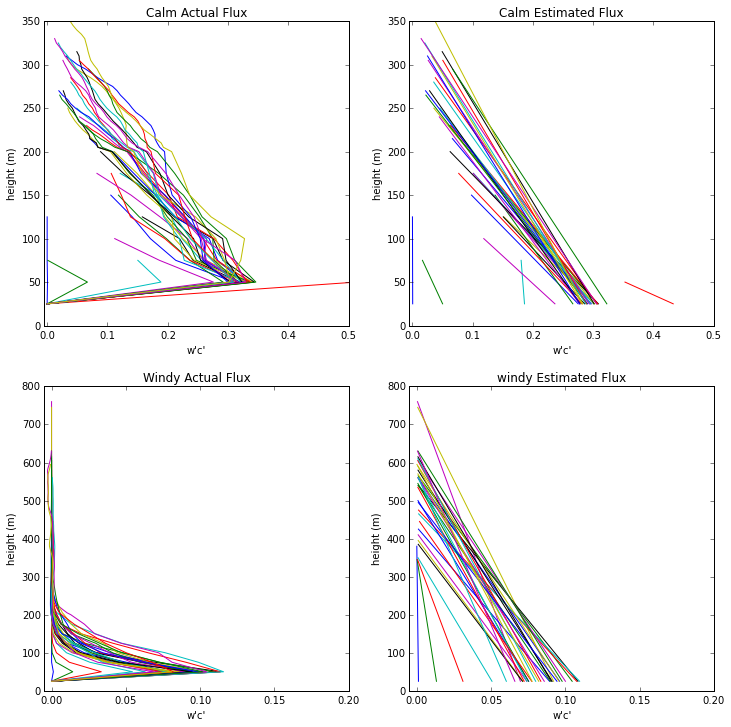

In [11]:
windy.TdBup()
calm.TdBup()
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_flux_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.wcBar[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_flux_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.wcBar[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(-.005,.5),xlabel="w'c'",ylabel='height (m)',title=('Calm Actual Flux'))
out=ax[0][1].set(xlim=(-.005,.5),xlabel="w'c'",ylabel='height (m)',title=('Calm Estimated Flux'))
out=ax[1][0].set(xlim=(-.005,.2),xlabel="w'c'",ylabel='height (m)',title=('Windy Actual Flux'))
out=ax[1][1].set(xlim=(-.005,.2),xlabel="w'c'",ylabel='height (m)',title=('windy Estimated Flux'))

# The calm flux profiles look pretty good!

## The windy flux profiles behave very poorly because of the advection of "clean" air from upwind

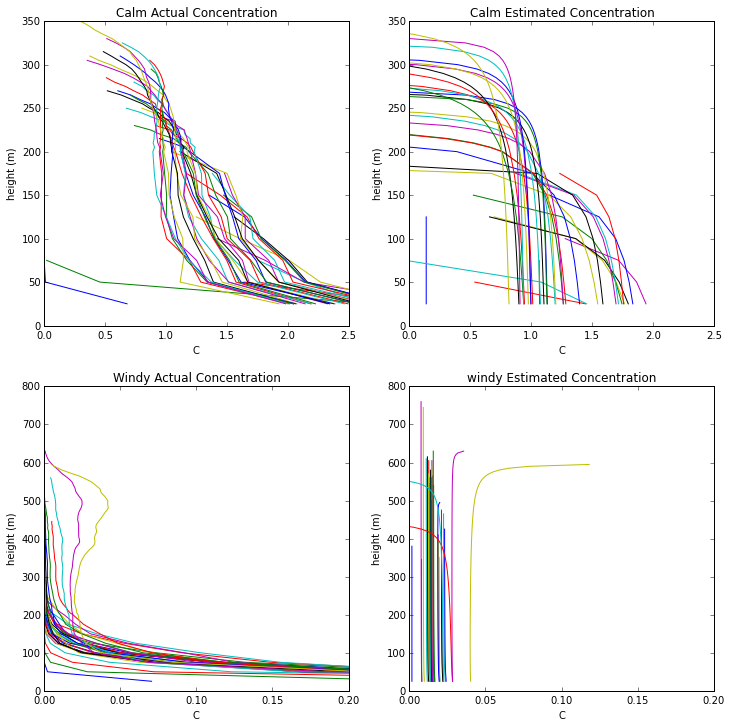

In [12]:
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.C[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.C[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(0,2.5),xlabel="C",ylabel='height (m)',title=('Calm Actual Concentration'))
out=ax[0][1].set(xlim=(0,2.5),xlabel="C",ylabel='height (m)',title=('Calm Estimated Concentration'))
out=ax[1][0].set(xlim=(0,.2),xlabel="C",ylabel='height (m)',title=('Windy Actual Concentration'))
out=ax[1][1].set(xlim=(0,.2),xlabel="C",ylabel='height (m)',title=('windy Estimated Concentration'))

## Same for the concnetration profiles, the windy profiles are not very realisitc.

# What about when I look at a patch downwnind with no flux?

/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:75: RuntimeWarning: divide by zero encountered in power
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:78: RuntimeWarning: invalid value encountered in multiply
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: invalid value encountered in true_divide


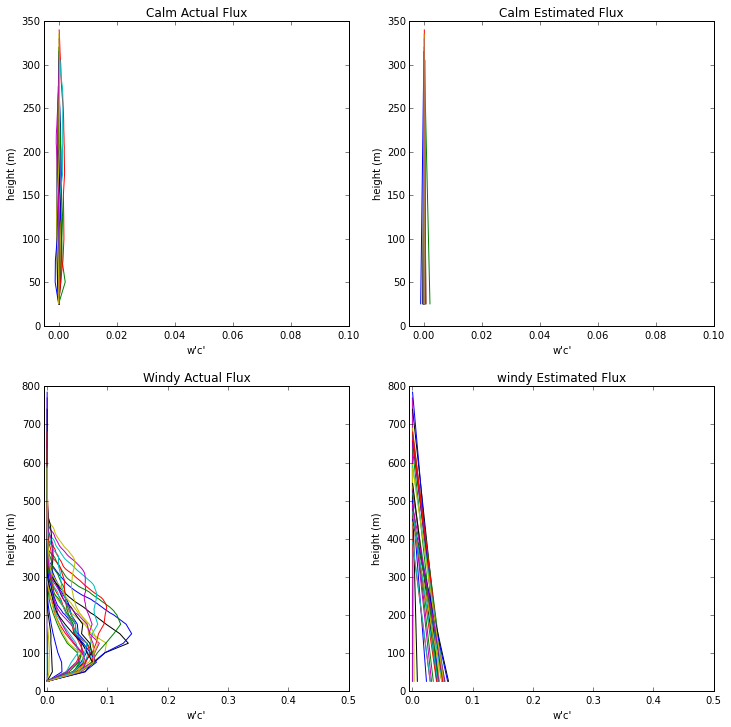

In [13]:
calm.Extract(calm.P2[0],calm.P2[1],calm.P2[2],calm.P2[3])
windy.Extract(windy.P2[0],windy.P2[1],windy.P2[2],windy.P2[3])

windy.TdBup()
calm.TdBup()
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_flux_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.wcBar[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_flux_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.wcBar[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(-.005,.1),xlabel="w'c'",ylabel='height (m)',title=('Calm Actual Flux'))
out=ax[0][1].set(xlim=(-.005,.1),xlabel="w'c'",ylabel='height (m)',title=('Calm Estimated Flux'))
out=ax[1][0].set(xlim=(-.005,.5),xlabel="w'c'",ylabel='height (m)',title=('Windy Actual Flux'))
out=ax[1][1].set(xlim=(-.005,.5),xlabel="w'c'",ylabel='height (m)',title=('windy Estimated Flux'))

## It works okay, calm profile has little advection so it obviously shows harly any flux,  agina advection complicates the windy profiles

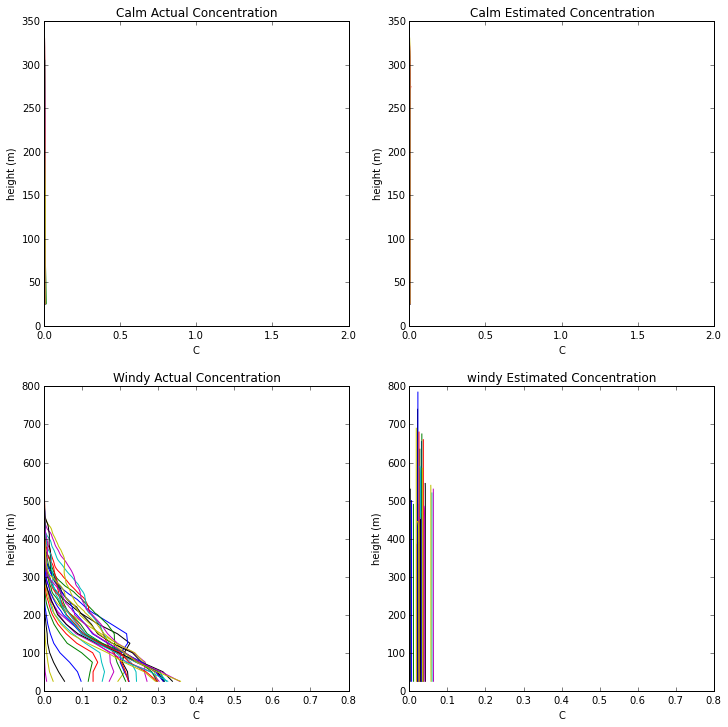

In [14]:
fig,ax = plt.subplots(2,2,figsize = (12,12))
for i in range (0,calm.count):
    ax[0][0].plot(calm.Tr_Pro[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
    ax[0][1].plot(calm.C[i,:calm.h_id[i]],calm.z[0:calm.h_id[i]])
for i in range (0,windy.count):
    ax[1][0].plot(windy.Tr_Pro[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
    ax[1][1].plot(windy.C[i,:windy.h_id[i]],windy.z[0:windy.h_id[i]])
out=ax[0][0].set(xlim=(0,2),xlabel="C",ylabel='height (m)',title=('Calm Actual Concentration'))
out=ax[0][1].set(xlim=(0,2),xlabel="C",ylabel='height (m)',title=('Calm Estimated Concentration'))
out=ax[1][0].set(xlim=(0,.8),xlabel="C",ylabel='height (m)',title=('Windy Actual Concentration'))
out=ax[1][1].set(xlim=(0,.8),xlabel="C",ylabel='height (m)',title=('windy Estimated Concentration'))

# The windy concentration estimates still make little physical sense.

## The inhomogeneity certainly caused issues with the steady state assumption, but I think the 